In [1]:
import pandas as pd
from datetime import datetime
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from scipy.signal import periodogram
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use('seaborn')

In [2]:
FIGSIZE = (15,8)

In [3]:
df = pd.read_csv('oil.csv',index_col='date',parse_dates=['date'])

In [4]:
df.index = df.index.to_period(freq='1D')

In [5]:
df['day_of_year'] = df.index.day_of_year

In [6]:
df['year'] = df.index.year

In [7]:
df.dropna(inplace=True)

In [8]:
df

,dcoilwtico,day_of_year,year
date,,,
2013-01-02,93.14,2,2013
2013-01-03,92.97,3,2013
2013-01-04,93.12,4,2013
2013-01-07,93.20,7,2013
2013-01-08,93.21,8,2013
...,...,...,...
2017-08-25,47.65,237,2017
2017-08-28,46.40,240,2017
2017-08-29,46.46,241,2017


### Visualizing seasonality for the different years

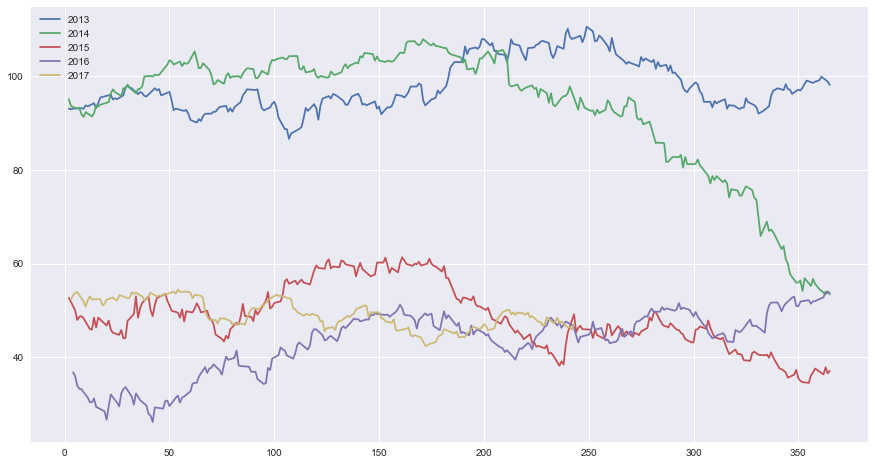

In [9]:
figure = plt.figure(figsize=FIGSIZE)
for y in df['year'].unique():
    plt.plot('day_of_year','dcoilwtico',data=df.query('year == @y'),label=str(y))
plt.legend()
plt.show()

In [10]:
df.query('year == 2016',inplace=True)

In [11]:
df.drop(columns=['year','day_of_year'],inplace=True)

### Using a periodogram to get the densities of the periods

In [12]:
spectrum, density = periodogram(df['dcoilwtico'],fs=365.,detrend='linear',scaling='spectrum')

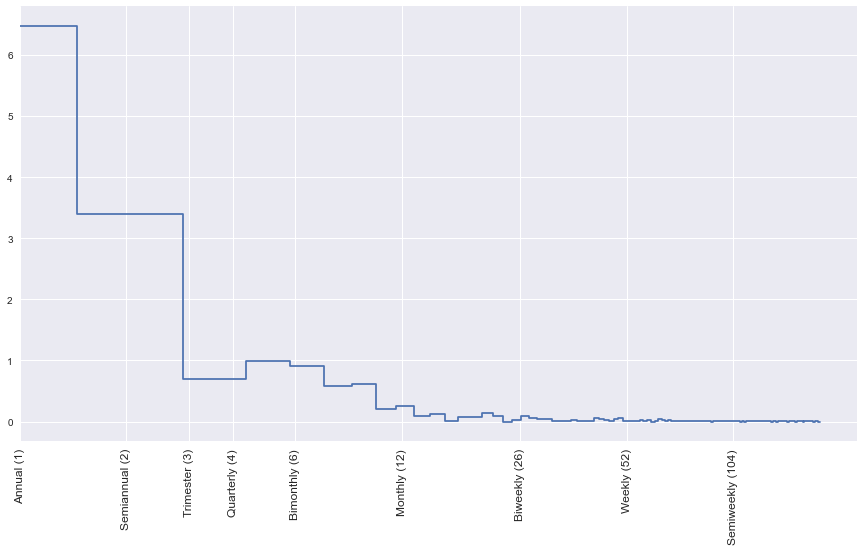

In [13]:
# plt.figure(figsize=(15,10))
figure, ax = plt.subplots(figsize=FIGSIZE)
ax.step(spectrum,density)
ax.set_xscale('log')
ax.set_xticks([1, 2, 3, 4, 6, 12, 26, 52, 104])
ax.set_xticklabels(
    [
        "Annual (1)",
        "Semiannual (2)",
        "Trimester (3)",
        "Quarterly (4)",
        "Bimonthly (6)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)",
        "Semiweekly (104)",
    ],
    rotation=90,
    fontdict={'size':12}
)
plt.show()

### Calendar Fourier to generate a pair if sine/cosine based on the order

In [14]:
fourier = CalendarFourier(freq='A',order=6)

In [15]:
# fig, ax = plt.subplots(figsize=(15,8))
# ax.scatter(range(df.index.shape[0]),df['dcoilwtico'],alpha=.5,edgecolors='purple',c='green')
# plt.show()

### Using deterministic process to generate dummy variables out of the index

In [16]:
dp = DeterministicProcess(
    index=df.index,
    constant=True,
    additional_terms=[fourier],
    seasonal=True,
    order=1,
    drop=True
)

In [17]:
X = dp.in_sample()
y = df['dcoilwtico']

### Fitting linear regression model

In [18]:
model = LinearRegression(fit_intercept=True)

In [19]:
model.fit(X,y)

LinearRegression()

In [20]:
prediction = pd.Series(model.predict(X),index=X.index)
# next 30 days forecast
forecast = dp.out_of_sample(60)
forecast = pd.Series(model.predict(forecast),index=forecast.index)

### Visualizing forecast vs predictions vs observations

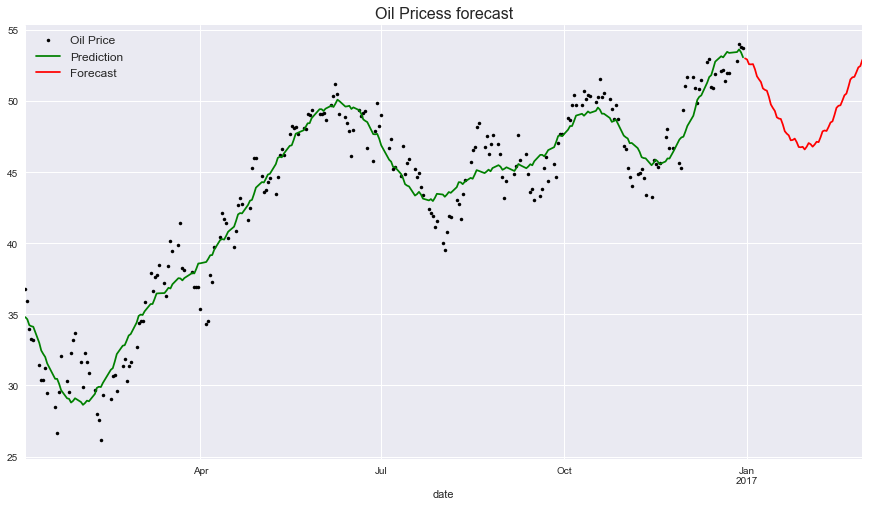

In [21]:
fig = plt.figure(figsize=FIGSIZE)
plt.title('Oil Pricess forecast',fontdict={'size':16})
ax = y.plot(style='.',color='black',label='Oil Price')
prediction.plot(ax=ax,label='Prediction',color='green')
forecast.plot(ax=ax,label='Forecast',color='red')
plt.legend(fontsize=12)
plt.show()